In [4]:
from ydf_model import evaluation
!.venv/bin/pip3 install -r requirements.txt

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import math
import ydf  # Yggdrasil Decision Forests
from sklearn.model_selection import train_test_split
from wurlitzer import sys_pipes
from sklearn.model_selection import KFold
import tqdm as tqdm
from sklearn.preprocessing import MinMaxScaler
from functools import partial

%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 10]

2025-03-28 21:19:55.152783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743211195.164603  141135 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743211195.168188  141135 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743211195.177953  141135 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743211195.177961  141135 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743211195.177963  141135 computation_placer.cc:177] computation placer alr

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to avoid TensorFlow using all GPU memory
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        # Set TensorFlow to use only the first GPU (if multiple GPUs available)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=4096 * 4)]  # Set memory limit to 4*4GB
        )

        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)

Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
def train_and_eval(model, train_ds, test_ds = None):
    # Optionally, add evaluation metrics.
    model.compile(metrics=["mse"])
    rmse = 0

    with sys_pipes():
        model.fit(x=train_ds)

    if test_ds is not None:
        evaluation = model.evaluate(x=test_ds, return_dict=True)
        rmse = math.sqrt(evaluation["mse"])

    return rmse

def latlon_to_xyz(lat, lon):
    lat, lon = np.radians(lat), np.radians(lon)
    x = np.cos(lat) * np.cos(lon)
    y = np.cos(lat) * np.sin(lon)
    z = np.sin(lat)
    return x, y, z

# Example: Normalize Cartesian coordinates between 0 and 1
def normalize_xyz(x, y, z):
    # Normalizing each coordinate to the [0, 1] range
    return (x + 1) / 2, (y + 1) / 2, (z + 1) / 2

In [5]:
ROOT_DIR = "temporary"
train_df = pd.read_csv(f'{ROOT_DIR}/Train.csv')
test_df = pd.read_csv(f'{ROOT_DIR}/Test.csv')
vocab_df = pd.read_csv(f'{ROOT_DIR}/variable_descriptions.csv')
admin_df = pd.read_csv(f'{ROOT_DIR}/zaf_adminboundaries_tabulardata.csv', sep=";")

admin_df = admin_df[["ADM4_PCODE", "AREA_SQKM", "ADM2_ID"]] # ADM3_ID
admin_df["AREA_SQKM"] = admin_df["AREA_SQKM"].str.replace(",", ".").astype(float)
train_df = pd.merge(train_df, admin_df, on="ADM4_PCODE", how="left")
test_df = pd.merge(test_df, admin_df, on="ADM4_PCODE", how="left")
label_column = "target"

default_columns = ["ward", "ADM4_PCODE"]
nul_cols = ["dw_12", "dw_13", "lan_13", "pw_08", "pw_07"] # Columns with null values
cat_columns = ["ADM2_ID"] # Categorical columns
ft_columns = default_columns + cat_columns

In [6]:
from sklearn.preprocessing import OneHotEncoder

scaler = MinMaxScaler()
def preprocess_df(input_df, is_train=False):
    drop_cols = []
    df = input_df.copy()
    df = df.drop(nul_cols, axis=1)

    ## Create a new feature
    df["phi"] = df["total_individuals"] / df["total_households"]
    df["id_area"] = df["total_individuals"] / df["AREA_SQKM"]
    df["hs_area"] = df["total_households"] / df["AREA_SQKM"]
    
    ## Normalize some columns
    norm_cols = ["phi", "NL", "id_area", "hs_area"]
    df[norm_cols] = scaler.fit_transform(df[norm_cols]) if is_train else scaler.transform(df[norm_cols])

    ## Encode categorical columns
    # encoded = categorical_encoder.fit_transform(df[cat_columns]) if is_train else categorical_encoder.transform(df[cat_columns])
    # encoded_df = pd.DataFrame(encoded, columns=categorical_encoder.get_feature_names_out(cat_columns))
    # df = pd.concat([df, encoded_df], axis=1)
    drop_cols = drop_cols + cat_columns
    
    ## Transform lat and lon to xyz
    df["x"], df["y"], df["z"] = zip(*df.apply(lambda x: latlon_to_xyz(x["lat"], x["lon"]), axis=1))
    df["x"], df["y"], df["z"] = zip(*df.apply(lambda x: normalize_xyz(x["x"], x["y"], x["z"]), axis=1))

    drop_cols = drop_cols + default_columns
    if len(drop_cols) > 0:
        df.drop(drop_cols, axis=1, inplace=True)
    
    return df

## Test preprocess_df
# preprocess_df(train_ds_pd, is_train=True).head()

We assume in the preprocessing that:
- We drop columns with null values.
- We remove the categorical columns because it is not the same in the train and test set.

In [45]:
from tensorflow.keras import layers
import keras_tuner as kt

def rmse(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError(reduction="sum_over_batch_size")
    return tf.sqrt(mse_loss(y_true, y_pred))

def build_model(hp, num_features):
    model = tf.keras.Sequential()

    # Start with Input layer
    model.add(layers.Input(shape=(num_features,)))

    # Hyperparameter: Number of dense layers (1 to 10)
    num_layers = hp.Int('num_layers', min_value=1, max_value=10, step=1)

    for i in range(num_layers):
        # Decreasing number of units as we go deeper
        units = hp.Int(f'units_{i}', min_value=10, max_value=max(1000 // (2**i), 10), step=10)
        model.add(layers.Dense(units=units, activation='relu'))

        # Adding Dropout layer with HP-selected rate
        dropout_rate = hp.Float(f'dropout_rate_{i}', min_value=0.0, max_value=0.9, step=0.1)
        model.add(layers.Dropout(rate=dropout_rate))

    # Output layer for regression
    model.add(layers.Dense(1))

    # Hyperparameter: Learning rate (1e-8 to 1e-1)
    hp_learning_rate = hp.Float('learning_rate', min_value=1e-8, max_value=1e-1, sampling='LOG')

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['mse','mae', rmse]
    )
    return model

In [47]:
X = train_df.drop(label_column, axis=1)
y = train_df[label_column]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = preprocess_df(X_train, is_train=True)
X_val = preprocess_df(X_val, is_train=False)
train_ds_pd = pd.concat([X_train, y_train], axis=1)
test_ds_pd = pd.concat([X_val, y_val], axis=1)

In [48]:
## Pre-set the number of features
num_features = len(X_train.columns)
build_model = partial(build_model, num_features=num_features)

tuner = kt.BayesianOptimization(build_model, objective='val_mse',
                     max_trials = 100,
                    # max_epochs=100,
                     overwrite=True,
                     # factor=3,
                     directory='/tmp/keras_tuning',
                     distribution_strategy=tf.distribute.MirroredStrategy(),
                     project_name='women_poverty')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

(x_train, y_train) = (X_train.to_numpy(), y_train.to_numpy())
(x_val, y_val) = (X_val.to_numpy(), y_val.to_numpy())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [49]:
tuner.search(x=x_train, y=y_train, epochs=100, validation_split=0.2, callbacks=[stop_early])

Trial 100 Complete [00h 00m 47s]
val_mse: 642.852294921875

Best val_mse So Far: 108.28132629394531
Total elapsed time: 00h 46m 54s


In [51]:
tuner.results_summary(num_trials=2)

Results summary
Results in /tmp/keras_tuning/women_poverty
Showing 2 best trials
Objective(name="val_mse", direction="min")

Trial 049 summary
Hyperparameters:
num_layers: 4
units_0: 880
dropout_rate_0: 0.5
learning_rate: 0.003984890293664518
units_1: 120
dropout_rate_1: 0.2
units_2: 40
dropout_rate_2: 0.2
units_3: 70
dropout_rate_3: 0.1
units_4: 30
dropout_rate_4: 0.30000000000000004
units_5: 20
dropout_rate_5: 0.1
units_6: 10
dropout_rate_6: 0.5
units_7: 10
dropout_rate_7: 0.4
units_8: 10
dropout_rate_8: 0.5
units_9: 10
dropout_rate_9: 0.5
Score: 108.28132629394531

Trial 079 summary
Hyperparameters:
num_layers: 10
units_0: 120
dropout_rate_0: 0.0
learning_rate: 0.04650218793481366
units_1: 60
dropout_rate_1: 0.0
units_2: 120
dropout_rate_2: 0.1
units_3: 30
dropout_rate_3: 0.2
units_4: 50
dropout_rate_4: 0.2
units_5: 20
dropout_rate_5: 0.4
units_6: 10
dropout_rate_6: 0.5
units_7: 10
dropout_rate_7: 0.6000000000000001
units_8: 10
dropout_rate_8: 0.1
units_9: 10
dropout_rate_9: 0.8
Sco

In [52]:
tuner.search_space_summary(extended=False)


Search space summary
Default search space size: 22
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': 'linear'}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 1000, 'step': 10, 'sampling': 'linear'}
dropout_rate_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
learning_rate (Float)
{'default': 1e-08, 'conditions': [], 'min_value': 1e-08, 'max_value': 0.1, 'step': None, 'sampling': 'log'}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 500, 'step': 10, 'sampling': 'linear'}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 250, 'step': 10, 'sampling': 'linear'}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_val

In [53]:
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 880)            │        55,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 880)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 120)            │       105,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 40)             │         4,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 40)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 70)             │         2,870 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 70)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            71 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 168,941 (659.93 KB)

 Trainable params: 168,941 (659.93 KB)

 Non-trainable params: 0 (0.00 B)

On peut remarquer que le meilleur modele est celui avec une architecture en tunel avec 5 couches denses et le dropout pour les premieres couches sont nulles. Le modele apprend donc a chaque couche a retenir les informations importantes.

In [55]:
## Use ydf instead of tfdf

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    history = model.fit(x=x_train, y=y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[stop_early])

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


Epoch 1/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 508051.2812 - mae: 302.7513 - mse: 508051.2812 - rmse: 444.5340 - val_loss: 580.3870 - val_mae: 22.4306 - val_mse: 580.3870 - val_rmse: 23.4785
Epoch 2/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1135.5439 - mae: 27.6639 - mse: 1135.5439 - rmse: 32.9479 - val_loss: 562.7111 - val_mae: 22.0331 - val_mse: 562.7111 - val_rmse: 23.1000
Epoch 3/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1531.4255 - mae: 27.1819 - mse: 1531.4255 - rmse: 34.3440 - val_loss: 540.8778 - val_mae: 21.5319 - val_mse: 540.8778 - val_rmse: 22.6239
Epoch 4/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1134.0680 - mae: 25.4646 - mse: 1134.0680 - rmse: 30.6422 - val_loss: 513.4265 - val_mae: 20.8847 - val_mse: 513.4265 - val_rmse: 22.0109
Epoch 5/100
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 790.8617 - mae: 24.2039 - mse: 790.8617 - rmse: 27.7253 - val_loss: 480.2451 - val_mae: 20.0746 - val_mse: 480.2451 - val_rmse: 21.2469
Epoch 6/10

Bien qu'un tuning des hyperparametres a ete fait, a un rmse de 8.6176, largement plus grand que celui obtenu avec le modele de decision forest.

YDF results plotting does not work with here so we will use the following code to plot the results.

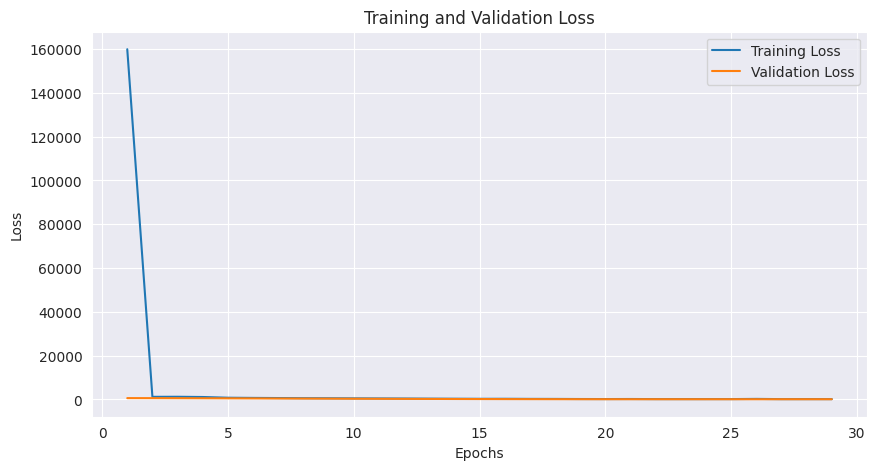

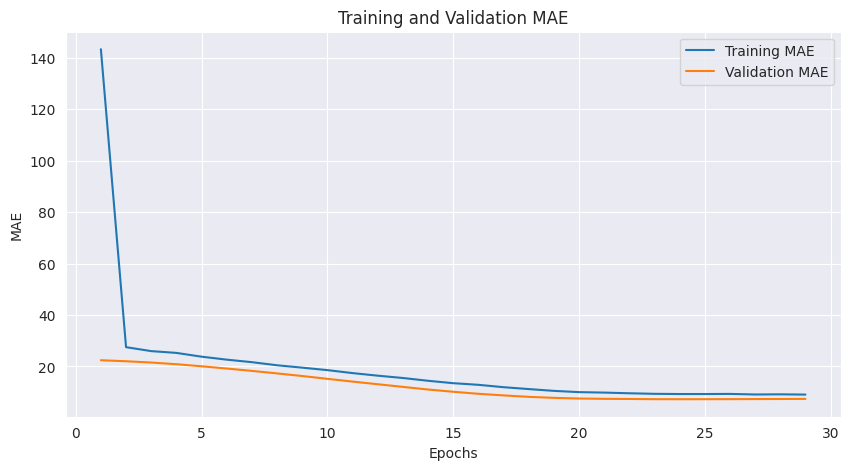

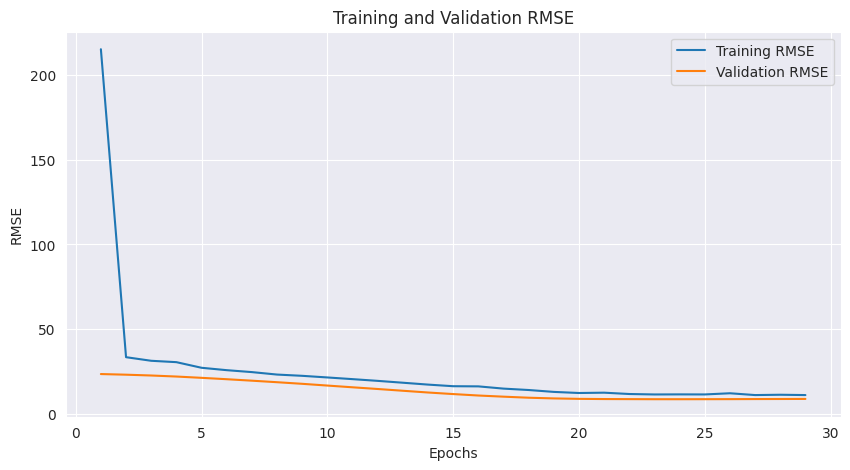

In [59]:
import matplotlib.pyplot as plt

# Your training history dictionary
history = history.history

epochs = range(1, len(history["loss"]) + 1)

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, history["loss"], label="Training Loss")
plt.plot(epochs, history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot Mean Absolute Error (MAE)
plt.figure(figsize=(10, 5))
plt.plot(epochs, history["mae"], label="Training MAE")
plt.plot(epochs, history["val_mae"], label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.grid(True)
plt.show()

# Plot Root Mean Squared Error (RMSE)
plt.figure(figsize=(10, 5))
plt.plot(epochs, history["rmse"], label="Training RMSE")
plt.plot(epochs, history["val_rmse"], label="Validation RMSE")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.title("Training and Validation RMSE")
plt.legend()
plt.grid(True)
plt.show()

In [56]:
with strategy.scope():
    evaluation = model.evaluate(x=X_val, y=y_val)

evaluation

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 89.3398 - mae: 7.8658 - mse: 89.3398 - rmse: 9.2493     


[79.79296112060547, 79.79296112060547, 7.391023635864258, 8.789944648742676]

My analysis:
- Comparing the rmse of the model with the one obtained with the decision forest model, we can see that the decision forest model is better.
- Looking at the training and validation loss, we could think that the model can be improved by training it for more epochs. But, the model is already overfitting. I set the early stopping to avoid this.
- We could also try to add more features or better preprocess the data.